In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from pathlib import Path
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from collections import defaultdict
import io
from tqdm.auto import tqdm
import tempfile

from PIL import Image
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from torchvision.transforms import v2 as transforms_v2
from pytorch_msssim import ssim, ms_ssim
import compressai

from Iwildcam_Pretrain import Autoencoder, Encoder, Decoder, IWildCamDataset, CompressaiWrapper, SimpleCompressaiModel
from lora_modules import LoRAConv2d, LoRALinear, LoRAConvTranspose2d

/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/compressai/models/video/google.py:353: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @amp.autocast(enabled=False)
[rank: 0] Seed set to 42


Device: cuda:0


In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

CHECKPOINT_PATH = "best_checkpoints/"
# HEIGHT = 96
# WIDTH = 160
HEIGHT = 96 * 2
WIDTH = 160 * 2
PRECISION = 32
DO_CACHING = False
# DATASET_ROOT = "/data/vision/beery/scratch/data/iwildcam_unzipped"
DATASET_ROOT = "/tmp/iwildcam_unzipped"

Device: cuda:0


In [4]:
def get_lora_model(
        latent_dim,
        lora_precision=None,
        loraize_encoder = False,  # no reason really to do this unless we want to reduce memory footprint
        loraize_decoder = True,
        finetune = True,
        model_type = 'simple',
):
    if finetune and lora_precision == 32:
        lora_precision = None

    lora_config = {
        torch.nn.Conv2d: {
            'cls': LoRAConv2d,
            'config': {
                'alpha': 8,
                'rank': 4,
                'rank_for': 'channels',
                'delta_bias': False, # True # TODO what does this do
                'precision': lora_precision,
            }
        },
        torch.nn.Linear: {
            'cls': LoRALinear,
            'config': {
                'rank': 4,
                'alpha': 2,
                'delta_bias':  False, # True # TODO what does this do
                'precision': lora_precision,
            }
        },
        torch.nn.ConvTranspose2d: {
            'cls': LoRAConvTranspose2d,
            'config': {
                'alpha': 8,
                'rank': 4,
                'rank_for': 'channels',
                'delta_bias': False, # True # TODO what does this do
                'precision': lora_precision,
            }
        }
    }

    # load two copies so we can lora-ize one
    if model_type == 'vanilla':
        pretrained_filename = sorted(glob.glob(os.path.join(CHECKPOINT_PATH, f"{latent_dim}-*.ckpt")))[0]
        if os.path.isfile(pretrained_filename):
            print(f"Found pretrained model for latent dim {latent_dim}, loading...")
            _model = Autoencoder.load_from_checkpoint(pretrained_filename)
            model  = Autoencoder.load_from_checkpoint(pretrained_filename)
        else:
            raise Exception
    elif model_type == 'hyperprior':
        pretrained_filename = sorted(glob.glob(os.path.join(CHECKPOINT_PATH, f"bmshj2018_hyperprior-*.ckpt")))[0]
        if os.path.isfile(pretrained_filename):
            print(f"Found pretrained model, loading...")
            model  = CompressaiWrapper.load_from_checkpoint(pretrained_filename)
            _model = CompressaiWrapper.load_from_checkpoint(pretrained_filename)
        else:
            raise Exception
    elif model_type == 'simple':
        pretrained_filename = sorted(glob.glob(os.path.join(CHECKPOINT_PATH, f"{latent_dim}-*.ckpt")))[0]
        if os.path.isfile(pretrained_filename):
            print(f"Found pretrained model, loading...")
            ckpt = torch.load(pretrained_filename)
            ckpt["state_dict"].pop("model.latent_codec.entropy_bottleneck._offset", None)
            ckpt["state_dict"].pop("model.latent_codec.entropy_bottleneck._quantized_cdf", None)
            ckpt["state_dict"].pop("model.latent_codec.entropy_bottleneck._cdf_length", None)
            with tempfile.NamedTemporaryFile("wb", suffix=".ckpt") as f:
                torch.save(ckpt, f)
                model  = CompressaiWrapper.load_from_checkpoint(f.name, strict=False, model=SimpleCompressaiModel(latent_dim))
                _model = CompressaiWrapper.load_from_checkpoint(f.name, strict=False, model=SimpleCompressaiModel(latent_dim))
            original_ckpt = torch.load(pretrained_filename)
            model_ckpt = {k[len("model."):]: v for k, v in original_ckpt["state_dict"].items() if k.startswith("model.")}
            model.model.load_state_dict(model_ckpt)
            _model.model.load_state_dict(model_ckpt)
        else:
            raise Exception
    else:
        raise ValueError('Invalid model_type')
    
    if not finetune:
        return model
    
    if model_type == 'vanilla':
        if loraize_encoder:
            for i, module in enumerate(_model.encoder.net.children()): 
                if type(module) in lora_config.keys():
                    lora_cls = lora_config[type(module)]['cls']
                    lora_params = lora_config[type(module)]['config']
                    model.encoder.net[i] = lora_cls(module, lora_params) # automatically freezes old parameters
                    model.encoder.net[i].enable_adapter()                # but we need to turn on the adapter path
                else:
                    # freeze all other parameters
                    for p in module.parameters():
                        p.requires_grad_(False)

        if loraize_decoder:
            for i, module in enumerate(_model.decoder.linear.children()): 
                if type(module) in lora_config.keys():
                    lora_cls = lora_config[type(module)]['cls']
                    lora_params = lora_config[type(module)]['config']
                    model.decoder.linear[i] = lora_cls(module, lora_params) # automatically freezes old parameters
                    model.decoder.linear[i].enable_adapter()                # but we need to turn on the adapter path
                else:
                    # freeze all other parameters
                    for p in module.parameters():
                        p.requires_grad_(False)

            for i, module in enumerate(_model.decoder.net.children()): 
                if type(module) in lora_config.keys():
                    lora_cls = lora_config[type(module)]['cls']
                    lora_params = lora_config[type(module)]['config']
                    model.decoder.net[i] = lora_cls(module, lora_params) # automatically freezes old parameters
                    model.decoder.net[i].enable_adapter()                # but we need to turn on the adapter path
                else:
                    # freeze all other parameters
                    for p in module.parameters():
                        p.requires_grad_(False)
    
    elif model_type == 'hyperprior':
            # freeze decoder stuff that won't be transmitted
        print("Freezing:")
        for name, param in model.model.g_s.named_parameters():
            print(name)
            param.requires_grad = False
        for name, param in model.model.h_s.named_parameters():
            print(name)
            param.requires_grad = False

        print("Fine-tuning:")
        for i, module in enumerate(_model.model.g_s.children()): 
            if type(module) in lora_config.keys():
                print("lora-izing", module)
                lora_cls = lora_config[type(module)]['cls']
                lora_params = lora_config[type(module)]['config']
                model.model.g_s[i] = lora_cls(module, lora_params) # automatically freezes old parameters
                model.model.g_s[i].enable_adapter()                # but we need to turn on the adapter path

        for i, module in enumerate(_model.model.h_s.children()): 
            if type(module) in lora_config.keys():
                print("lora-izing", module)
                lora_cls = lora_config[type(module)]['cls']
                lora_params = lora_config[type(module)]['config']
                model.model.h_s[i] = lora_cls(module, lora_params) # automatically freezes old parameters
                model.model.h_s[i].enable_adapter()                # but we need to turn on the adapter path
    elif model_type == 'simple':
            # freeze decoder stuff that won't be transmitted
        print("Freezing:")
        for name, param in model.model.g_s.named_parameters():
            print(name)
            param.requires_grad = False
        for name, param in model.model.latent_codec.named_parameters():
            print(name)
            param.requires_grad = False

        print("Fine-tuning:")
        for i, module in enumerate(_model.model.g_s.children()): 
            if type(module) in lora_config.keys():
                print("lora-izing", module)
                lora_cls = lora_config[type(module)]['cls']
                lora_params = lora_config[type(module)]['config']
                model.model.g_s[i] = lora_cls(module, lora_params) # automatically freezes old parameters
                model.model.g_s[i].enable_adapter()                # but we need to turn on the adapter path

        # for i, module in enumerate(_model.model.latent_codec.children()): 
        #     if type(module) in lora_config.keys():
        #         print("lora-izing", module)
        #         lora_cls = lora_config[type(module)]['cls']
        #         lora_params = lora_config[type(module)]['config']
        #         model.model.latent_codec[i] = lora_cls(module, lora_params) # automatically freezes old parameters
        #         model.model.latent_codec[i].enable_adapter()     
    else:
        raise ValueError('Invalid model_type')

    del _model # get rid of the clone
    return model

In [5]:
def compute_bits_per_pixel(model, latent_dim, lora_precision, width, height):
    param_size = 0
    for name, param in model.named_parameters():
        if "delta" in name:
            param_size += param.nelement() * (lora_precision / 8)

    # assume we don't have to transmit these if they are fixed -- this would be alpha, rank hyperparams
    buffer_size = 0

    latent_size = latent_dim * 4  # TODO: this is for full precision models, handle quantized models as well


    param_bpp = 8 * (param_size + buffer_size) / (width * height)
    latent_bpp = 8 * latent_size / (width * height)

    return param_bpp, latent_bpp

In [ ]:
our_test_set_ids = [292, 181, 430, 20, 4]
latent_dim = 8

results = []

for lora_precision in [-1, 0, 4, 8, 32]:
    finetune = lora_precision is not None and lora_precision != 0
    finetune_lora = lora_precision > 0

    for loc_id in our_test_set_ids:
        test_set = IWildCamDataset(Path(DATASET_ROOT), split="test")
        if DO_CACHING:
            test_set.cache_on_device_(device)
            test_set._cache = test_set._cache[[idx for idx, i in enumerate(test_set.data['images']) if i['location'] == loc_id]]
        test_set.data['images'] = [i for i in test_set.data['images'] if i['location'] == loc_id]
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=16 if not DO_CACHING else 0)

        model = get_lora_model(latent_dim, lora_precision, finetune=finetune_lora)
        # print(model)
        # for n, p in model.named_parameters():
        #     print(f"{n}: {p.requires_grad}")
        
        # Freeze decoder if specified
        # TODO remove this once lora-ize decoder works
        # freeze_decoder = True
        # if freeze_decoder:
        # for param in model.decoder.parameters():
        #     param.requires_grad = False
        # print(f"Decoder frozen for location {loc_id}")

        trainer = pl.Trainer(
            default_root_dir=os.path.join(CHECKPOINT_PATH, f"iwildcam_loc_{loc_id}"),
            accelerator="gpu" if str(device).startswith("cuda") else "cpu",
            precision=PRECISION,
            devices=1,
            max_epochs=1,
            gradient_clip_val=0.5,
            detect_anomaly=True,
            callbacks=[
                ModelCheckpoint(save_weights_only=True),
                LearningRateMonitor("epoch")
            ]
        )

        # Train the model
        # Overfit to the test set
        if finetune:
            trainer.fit(model, test_loader, test_loader)
            save_path = os.path.join(CHECKPOINT_PATH, f"iwildcam_latent_dim={latent_dim}_lora_loc={loc_id}.ckpt")
            trainer.save_checkpoint(save_path)

        test_metrics = trainer.test(model=model, dataloaders=test_loader)[0]

        # test_reconstruction_error = test_results[0]['test_loss']
        # test_reconstruction_error /= len(test_loader) # TODO: I think what we get from test() is a sum over batches? Timm: docs say default aggregation is torch.mean

        param_bpp, latent_bpp = compute_bits_per_pixel(model, latent_dim, lora_precision, WIDTH, HEIGHT)

        # Store results
        results.append(dict(
            finetuned=finetune,
            lora_precision=lora_precision,
            param_bpp=param_bpp,
            latent_bpp=latent_bpp,
            loc_id=loc_id,
            n_images=len(test_set.data['images']),
            **test_metrics,
        ))

        # release memory
        del test_set
        del model
        del trainer
        torch.cuda.empty_cache()

    # # Step 6: Visualize the results
    # # Bar chart of reconstruction error by location
    # locations, num_images, errors = zip(*results)

    # # Bar chart
    # plt.figure(figsize=(10, 6))
    # plt.bar(locations, errors, color='skyblue', edgecolor='black')
    # plt.xlabel("Location ID", fontsize=12)
    # plt.ylabel("Reconstruction Error", fontsize=12)
    # plt.title("Reconstruction Error by Location", fontsize=14)
    # plt.grid(True)
    # plt.show()

    # # Scatter plot of number of images vs. reconstruction error
    # plt.figure(figsize=(10, 6))
    # plt.scatter(num_images, errors, color='red', edgecolor='black', s=100)
    # plt.xlabel("Number of Images", fontsize=12)
    # plt.ylabel("Reconstruction Error", fontsize=12)
    # plt.title("Number of Images vs. Reconstruction Error", fontsize=14)
    # plt.grid(True)
    # plt.show()

Found pretrained model, loading...


/tmp/ipykernel_37298/4146912431.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(pretrained_filename)
/data/vision/beery/scratch/timm/micromamba/envs/a

/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 5/5 [00:12<00:00,  0.41it/s, v_num=0, train_loss_step=0.00623, val_loss_step=0.00569, val_loss_epoch=0.00544, train_loss_epoch=0.0056]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 5/5 [00:12<00:00,  0.40it/s, v_num=0, train_loss_step=0.00623, val_loss_step=0.00569, val_loss_epoch=0.00544, train_loss_epoch=0.0056]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:01<00:00,  3.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.005437707994133234
      test_ms_ssim           0.791602373123169
        test_ssim           0.4771568775177002
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model, loading...


You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                  | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------------
0 | model | SimpleCompressaiModel | 7.5 M  | train | [2, 3, 320, 192] | ?        
---------------------------------------------------------------------------------------
7.5 M     Trainable params
0         Non-trainable params
7.5 M     Total params
29.905    Total estimated model params size (MB)
351       Modules in train mode
0         Modules in eval mode


/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 1/1 [00:03<00:00,  0.32it/s, v_num=0, train_loss_step=0.00179, val_loss_step=0.00315, val_loss_epoch=0.00315, train_loss_epoch=0.00179]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:03<00:00,  0.29it/s, v_num=0, train_loss_step=0.00179, val_loss_step=0.00315, val_loss_epoch=0.00315, train_loss_epoch=0.00179]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.95it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.003147974843159318
      test_ms_ssim          0.8547487854957581
        test_ssim           0.6617271900177002
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model, loading...


You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                  | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------------
0 | model | SimpleCompressaiModel | 7.5 M  | train | [2, 3, 320, 192] | ?        
---------------------------------------------------------------------------------------
7.5 M     Trainable params
0         Non-trainable params
7.5 M     Total params
29.905    Total estimated model params size (MB)
351       Modules in train mode
0         Modules in eval mode


In [35]:
jpeg_results = []
jpeg_sample_size = 100  # TODO: increase

for loc_id in our_test_set_ids:
    test_set = IWildCamDataset(Path(DATASET_ROOT), split="test")
    test_set.data['images'] = [i for i in test_set.data['images'] if i['location'] == loc_id]
    test_set.data['images'] = np.random.default_rng(seed=42).choice(test_set.data['images'], jpeg_sample_size)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=16 if not DO_CACHING else 0)

    for batch in tqdm(test_loader):
        for el in batch:
            pil_img = Image.fromarray((el.cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8))

            for quality in np.linspace(start=0, stop=100, num=6):

                img_byte_arr = io.BytesIO()
                pil_img.save(img_byte_arr, format='JPEG', quality=int(quality.item()))

                el_bpp = (len(img_byte_arr.getvalue()) * 8) / (el.shape[1] * el.shape[1])

                pil_img = Image.open(img_byte_arr, mode='r')

                el_reconstructed = transforms_v2.ToTensor()(transforms_v2.ToDtype(torch.float32, scale=True)(pil_img))

                el_ssim = ssim(el[None, ...], el_reconstructed[None, ...], 1)
                try:
                    el_ms_ssim = ms_ssim(el[None, ...], el_reconstructed[None, ...], 1)
                except:
                    el_ms_ssim = -1
                jpeg_results.append(dict(quality=quality, bpp=el_bpp, ssim=el_ssim, ms_ssim=el_ms_ssim))

pd.DataFrame(jpeg_results).to_csv("cache/jpeg_results.csv")

  0%|          | 0/1 [00:00<?, ?it/s]/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
100%|██████████| 1/1 [00:12<00:00, 12.95s/it]


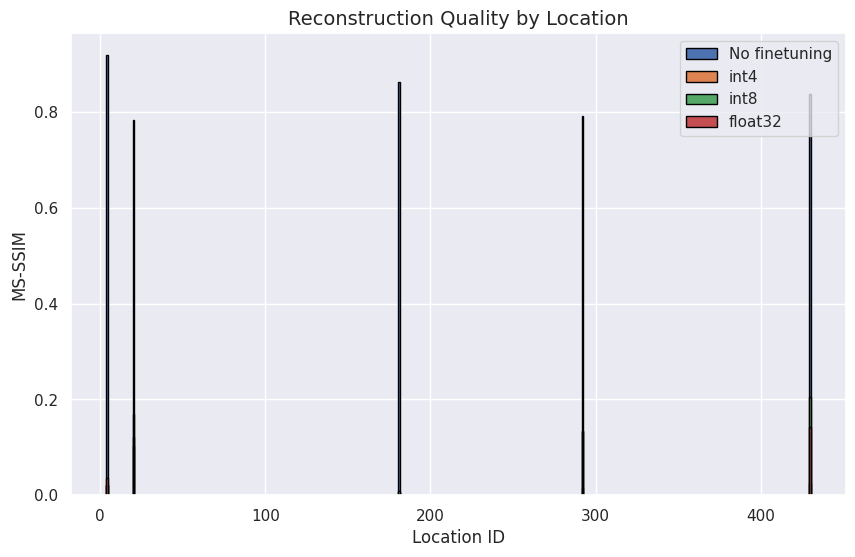

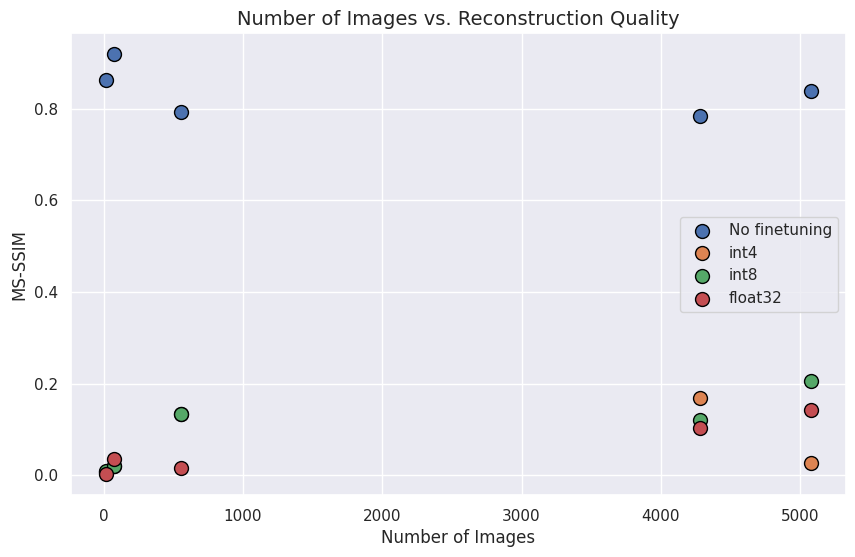

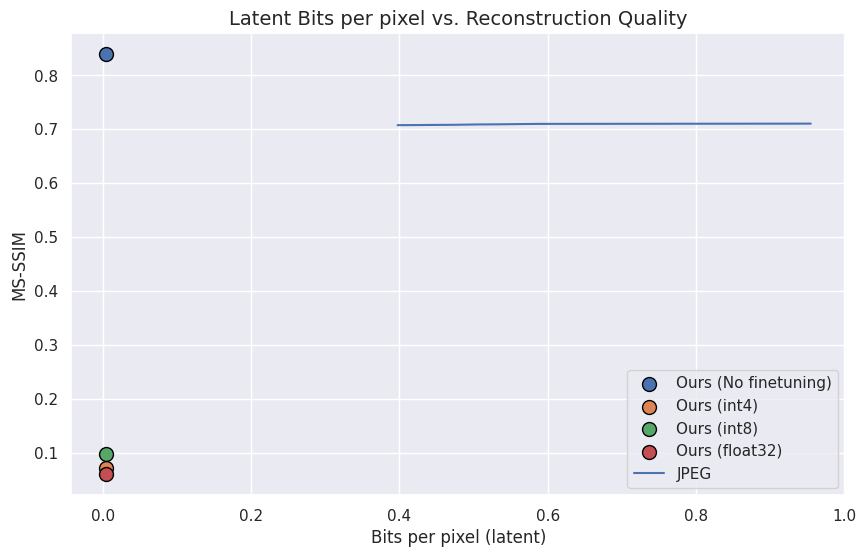

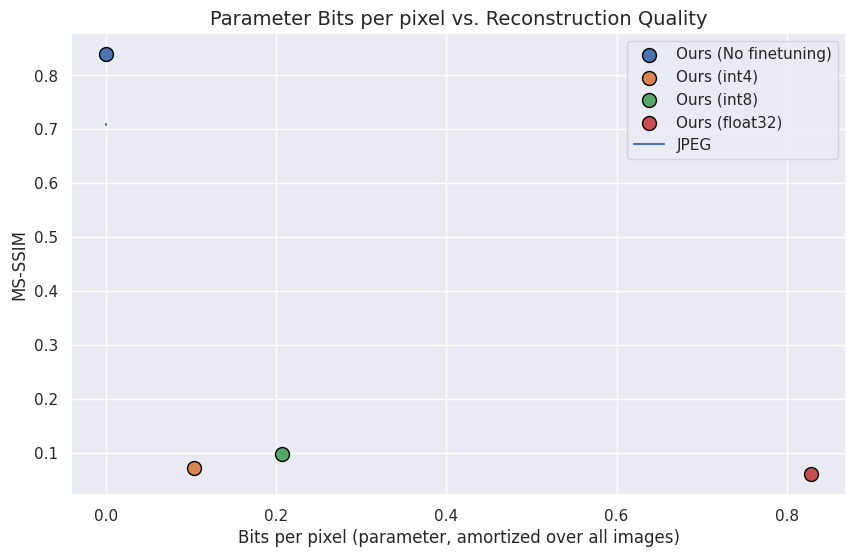

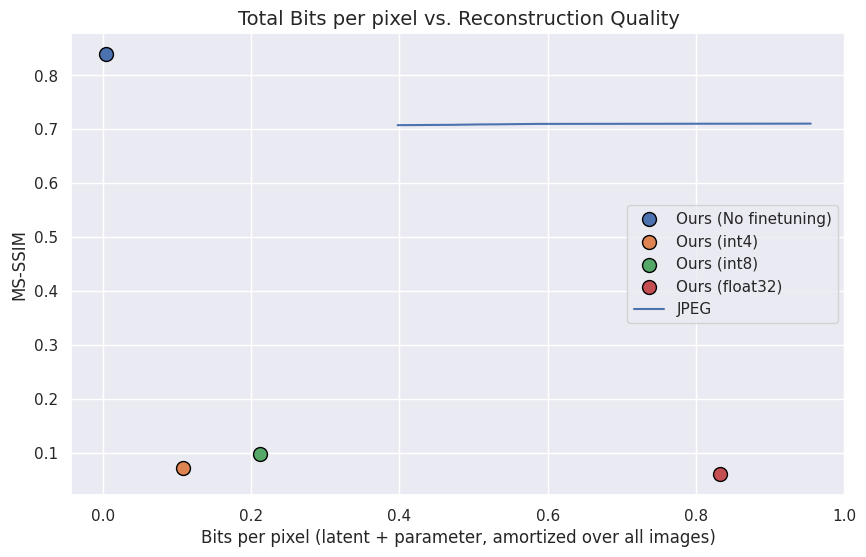

In [ ]:
# Step 6: Visualize the results
# Bar chart of reconstruction error by location

lora_precision_labels = dict({ 32: "float32", 8: "int8", 4: "int4", 0: "No finetuning", -1: "Full finetuning" })

results_df = pd.DataFrame(results)
results_df["lora_precision"] = results_df["lora_precision"].fillna(-1)

jpeg_df = pd.DataFrame(jpeg_results)

# has_mssim = np.isfinite(results_df["test_ms_ssim"]).any() and np.isfinite(jpeg_df["ms_ssim"]).any()
has_mssim = True

# Bar chart
plt.figure(figsize=(10, 6))
for lora_precision in results_df["lora_precision"].unique():
    plt.bar(results_df[results_df["lora_precision"] == lora_precision]["loc_id"], results_df[results_df["lora_precision"] == lora_precision]["test_ms_ssim" if has_mssim else "test_ssim"], edgecolor='black', label=lora_precision_labels[lora_precision])
plt.xlabel("Location ID", fontsize=12)
plt.ylabel("MS-SSIM" if has_mssim else "SSIM", fontsize=12)
plt.title("Reconstruction Quality by Location", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

# Scatter plot of number of images vs. reconstruction error
plt.figure(figsize=(10, 6))
for lora_precision in results_df["lora_precision"].unique():
    plt.scatter(results_df[results_df["lora_precision"] == lora_precision]["n_images"], results_df[results_df["lora_precision"] == lora_precision]["test_ms_ssim" if has_mssim else "test_ssim"], edgecolor='black', s=100, label=lora_precision_labels[lora_precision])
plt.xlabel("Number of Images", fontsize=12)
plt.ylabel("MS-SSIM" if has_mssim else "SSIM", fontsize=12)
plt.title("Number of Images vs. Reconstruction Quality", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

# Latent Bits per pixel
plt.figure(figsize=(10, 6))
for lora_precision in results_df["lora_precision"].unique():
    plt.scatter(results_df[results_df["lora_precision"] == lora_precision]["latent_bpp"].mean(), results_df[results_df["lora_precision"] == lora_precision]["test_ms_ssim" if has_mssim else "test_ssim"].mean(), edgecolor='black', s=100, label=f"Ours ({lora_precision_labels[lora_precision]})")
jpeg_df_agg = jpeg_df.groupby("quality").mean()
plt.plot(jpeg_df_agg["bpp"], jpeg_df_agg["ms_ssim" if has_mssim else "ssim"], label="JPEG")
plt.xlabel("Bits per pixel (latent)", fontsize=12)
plt.ylabel("MS-SSIM" if has_mssim else "SSIM", fontsize=12)
plt.title("Latent Bits per pixel vs. Reconstruction Quality", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

# Param Bits per pixel
plt.figure(figsize=(10, 6))
for lora_precision in results_df["lora_precision"].unique():
    plt.scatter((results_df[results_df["lora_precision"] == lora_precision]["param_bpp"] / results_df[results_df["lora_precision"] == lora_precision]["n_images"]).mean(), results_df[results_df["lora_precision"] == lora_precision]["test_ms_ssim" if has_mssim else "test_ssim"].mean(), edgecolor='black', s=100, label=f"Ours ({lora_precision_labels[lora_precision]})")
plt.plot(0 * jpeg_df_agg["bpp"], jpeg_df_agg["ms_ssim" if has_mssim else "ssim"], label="JPEG")
plt.xlabel("Bits per pixel (parameter, amortized over all images)", fontsize=12)
plt.ylabel("MS-SSIM" if has_mssim else "SSIM", fontsize=12)
plt.title("Parameter Bits per pixel vs. Reconstruction Quality", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

# Total Bits per pixel
plt.figure(figsize=(10, 6))
for lora_precision in results_df["lora_precision"].unique():
    plt.scatter(results_df[results_df["lora_precision"] == lora_precision]["latent_bpp"].mean() + (results_df[results_df["lora_precision"] == lora_precision]["param_bpp"] / results_df[results_df["lora_precision"] == lora_precision]["n_images"]).mean(), results_df[results_df["lora_precision"] == lora_precision]["test_ms_ssim" if has_mssim else "test_ssim"].mean(), edgecolor='black', s=100, label=f"Ours ({lora_precision_labels[lora_precision]})")
plt.plot(jpeg_df_agg["bpp"], jpeg_df_agg["ms_ssim" if has_mssim else "ssim"], label="JPEG")
plt.xlabel("Bits per pixel (latent + parameter, amortized over all images)", fontsize=12)
plt.ylabel("MS-SSIM" if has_mssim else "SSIM", fontsize=12)
plt.title("Total Bits per pixel vs. Reconstruction Quality", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()